# Regression

preliminary operations

In [1]:
from google.colab import files # in order to be able to download and upload files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, KFold

import os
from tqdm.notebook import tqdm

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Datasets

In [4]:
# get the datasets

!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv

all_train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

--2020-11-29 13:47:35--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-11-29 13:47:35 (32.8 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2020-11-29 13:47:35--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

In [5]:
class CsvDataset(Dataset):

  def __init__(self, data_df, transform=None):
    """
    Args:
        data_df: pd.DataFrame object with the data
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.data = data_df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    sample = (row.input, row.label)

    if self.transform:
      sample = self.transform(sample)
    return sample

class ArrayDataset(Dataset):
  def __init__(self, data_array, transform=None):
    self.transform = transform
    self.data = data_array

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = (self.data[idx,0], self.data[idx,1])
    if self.transform:
      sample = self.transform(sample)
    return sample


class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
      x,y = sample
      return (torch.tensor([x]).float(), torch.tensor([y]).float())

In [6]:
composed_transform = transforms.Compose([ToTensor()])

all_train_dataset = CsvDataset(all_train_df, transform=composed_transform)
test_dataset   = CsvDataset(test_df, transform=composed_transform)

#### Save datasets to local machine to enable offline work

In [ ]:
files.download('regression_dataset/train_data.csv')
files.download('regression_dataset/test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Upload files from local

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
User uploaded file "test_data.csv" with length 3788 bytes
User uploaded file "train_data.csv" with length 3776 bytes


## Basic solution

### Network definition

In [7]:
class Net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No, activation_function):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=No)

    self.act = activation_function

    print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)

    return x

In [8]:
class Evolver(object):

  def __init__(self, net, optimizer, loss_function, train_dataloader, val_dataloader, additional_params):
    '''
    Class for evolving the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.
    '''
    self.net = net
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []
    self.additional_params = additional_params


  def stop_learning(self,epoch_num):
    return False


  def evolve(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(range(num_epochs)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss= []
      self.net.train() # Training mode
      for sample_batched in self.train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # set previous gradients to 0
        self.optimizer.zero_grad()
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Backpropagation
        loss.backward()
        # Update the weights
        self.optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

      # Save average train loss
      train_loss = np.mean(train_loss)
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      ### VALIDATION
      val_loss= []
      self.net.eval() # Evaluation mode
      with torch.no_grad(): # Disable gradient tracking
        for sample_batched in self.val_dataloader:
          # Move data to device
          x_batch = sample_batched[0].to(device)
          label_batch = sample_batched[1].to(device)
          # Forward pass
          out = self.net(x_batch)
          # Compute loss
          loss = self.loss_function(out,label_batch)
          # Save val loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        if verbose:
          print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        self.val_loss_log.append(val_loss)

      if self.stop_learning(epoch_num):
        break
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Train loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average train      loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))

  def plot(self,train_df,val_df):
    x_min = -5
    x_max = 5

    x_vec = torch.linspace(x_min,x_max,1000).to(device)
    x_vec = x_vec.unsqueeze(-1)

    self.net.eval()
    with torch.no_grad():
      y_vec = self.net(x_vec)

    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    plt.figure(figsize=(12,8))
    plt.plot(x_vec, y_vec, label='Network output')
    plt.scatter(train_df.input,train_df.label,label='Training points')
    plt.scatter(val_df.input,val_df.label,label='Validation points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()


  def test(self,test_df,plot=False):
    test_dataloader = DataLoader(CsvDataset(test_df,transform=composed_transform),batch_size=len(test_df),shuffle=False,num_workers=0)

    test_loss= []
    self.net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss.append(loss_batch)

      # Save average validation loss
      test_loss = np.mean(test_loss)

      if plot:
        x_min = np.min(test_df.input)
        x_max = np.max(test_df.input)

        x_vec = torch.linspace(x_min,x_max,1000).to(device)
        x_vec = x_vec.unsqueeze(-1)

        self.net.eval()
        with torch.no_grad():
          y_vec = self.net(x_vec)

        # Convert x_vec and y_vec to numpy one dimensional arrays
        x_vec = x_vec.squeeze().cpu().numpy()
        y_vec = y_vec.squeeze().cpu().numpy()

        # Plot output
        plt.figure(figsize=(12,8))
        plt.plot(x_vec, y_vec, label='Network output')
        plt.scatter(test_df.input,test_df.label,label='Test points',color='red')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.legend()
        plt.show()

        print('Average test loss: %.3f' % test_loss)

      return test_loss 

### Setting all hyperparameters

In [18]:
Ni = No = 1 # forced
Nh1 = 128
Nh2 = 128
activation_function = nn.Tanh()

# torch.manual_seed(0)

net = Net(Ni,Nh1,Nh2,No,activation_function=activation_function).to(device)

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0)

loss_function = nn.MSELoss()

val_perc = 0.1
train_batch_size = 10

train_df, val_df = train_test_split(all_train_df,test_size=val_perc,shuffle=True)
train_dataloader = DataLoader(CsvDataset(train_df,transform=composed_transform), batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(CsvDataset(val_df,transform=composed_transform), batch_size=len(val_df), shuffle=False, num_workers=0)


nature = Evolver(net=net,optimizer=optimizer,loss_function=loss_function,train_dataloader=train_dataloader,val_dataloader=val_dataloader,additional_params=[])

Network initialized


In [ ]:
nature.evolve(2000,verbose= False)

### Plots

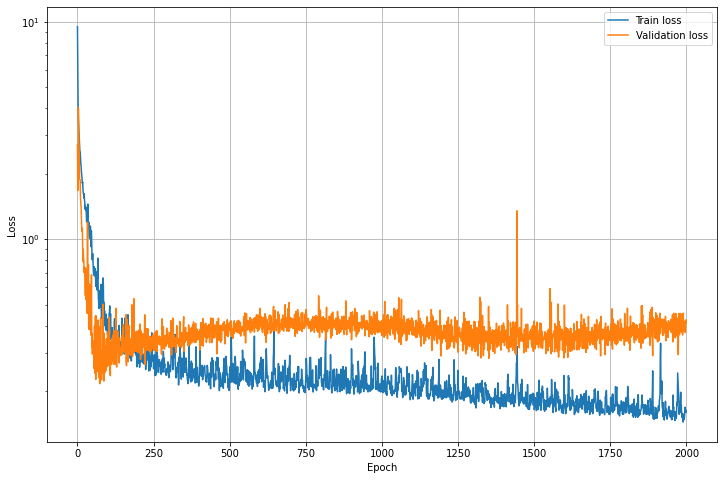

Average train      loss in the last 10 epochs: 0.1576
Average validation loss in the last 10 epochs: 0.3984


In [ ]:
nature.plot_losses()

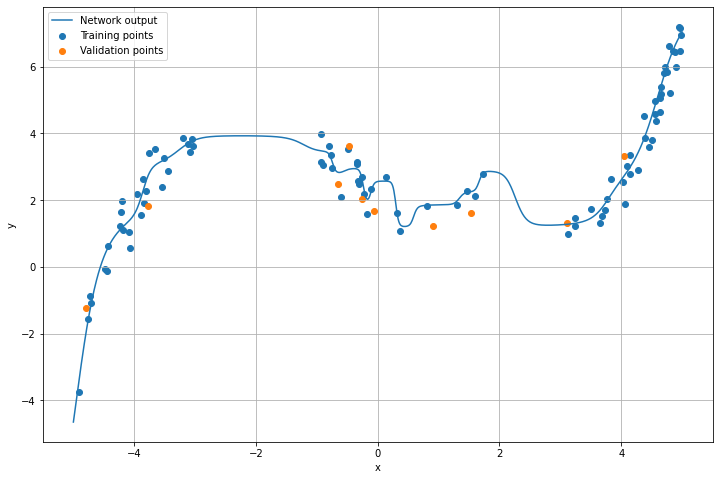

In [ ]:
nature.plot(train_df,val_df)

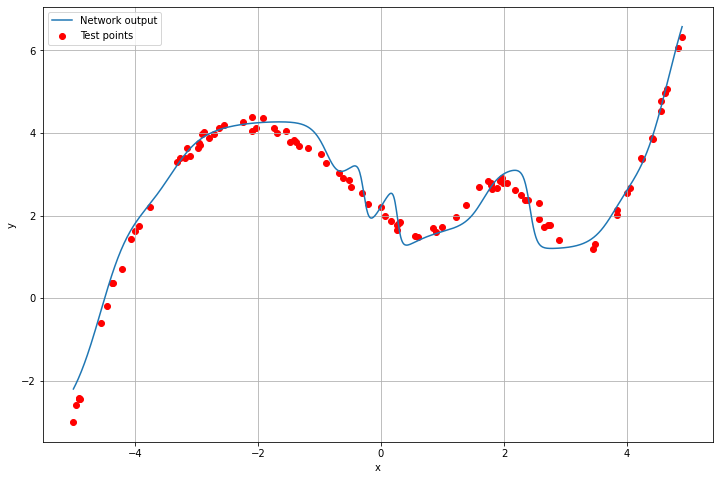

Average test loss: 0.096


0.09562116

In [ ]:
nature.test(test_df,plot=True)

## More advanced methods

### K Fold cross validation

#### Implementing K Fold

In [9]:
class KFoldCrossValidator(object):

  def __init__(self, k, shuffle=False, all_train_df=None, net_type=None, net_params=None, optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size = 10, evolver_type=None, evolver_additional_params=[]):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_df = all_train_df

    self.net_type = net_type
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.loss_function = loss_function
    self.train_batch_size = train_batch_size

    self.evolver_type = evolver_type
    self.evolver_additional_params = evolver_additional_params

    self.evolvers = []
    self.train_dfs = []
    self.val_dfs = []

    for train_idx, val_idx in self.splitter.split(self.all_train_df):
      train_df = self.all_train_df.iloc[train_idx]
      val_df = self.all_train_df.iloc[val_idx]
      self.train_dfs.append(train_df)
      self.val_dfs.append(val_df)

      train_dataloader = DataLoader(CsvDataset(train_df,transform=composed_transform), batch_size=train_batch_size, shuffle=True, num_workers=0)
      val_dataloader = DataLoader(CsvDataset(val_df,transform=composed_transform), batch_size=len(val_df), shuffle=False, num_workers=0)

      net = self.net_type(*self.net_params).to(device)

      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(net.parameters(),**self.optimizer_params)
      else:
        optimizer = self.optimizer_type(net.parameters(),*self.optimizer_params)

      evolver = self.evolver_type(net=net,optimizer=optimizer,loss_function=loss_function,
                                  train_dataloader=train_dataloader,val_dataloader=val_dataloader, additional_params=self.evolver_additional_params)

      self.evolvers.append(evolver)


  def run(self,num_epochs,loss_sample_size=10):
    for evolver in self.evolvers:
      evolver.evolve(num_epochs)

    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.evolvers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.evolvers])
    
    return avg_train_loss, avg_val_loss
    

#### Testing

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver
evolver_additional_params = []


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(1000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.3136631, 0.39647895)

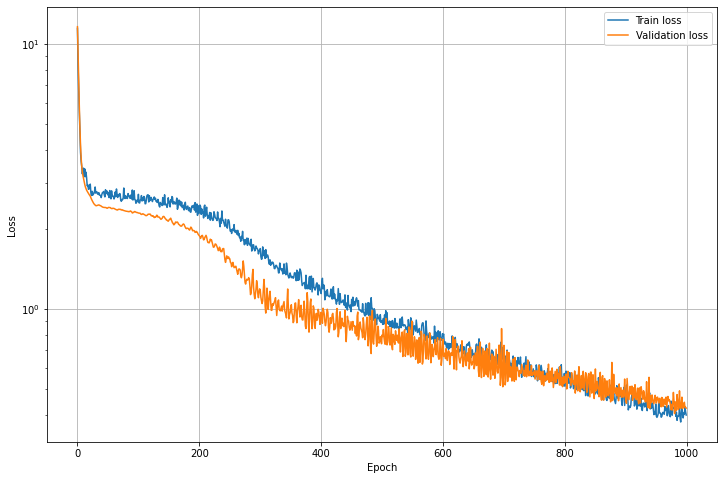

Average train      loss in the last 10 epochs: 0.4041
Average validation loss in the last 10 epochs: 0.4331


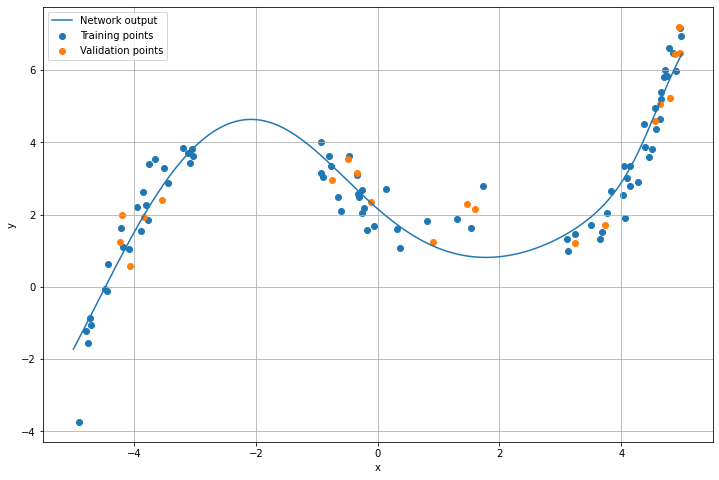

In [ ]:
idx = 4

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

### Early stopping

To prevent overfitting and thus speeding up the process

In [10]:
class Evolver_es(Evolver):

  def __init__(self, *args, **kwargs):
    '''
    If after 'patience' epochs the validation loss doesn't decrease, learning stops
    '''
    super().__init__(*args, **kwargs)

    self.patience = int(self.additional_params[0])
    self.current_avg_loss = np.infty
    # self.current_train_loss = np.infty

  def stop_learning(self,epoch_num):
    if epoch_num < 100: # at least do 100 epochs
      return False
    if epoch_num % self.patience == 0:
      cal = np.mean(self.val_loss_log[-self.patience:])
      # self.current_train_loss = np.mean(self.train_loss_log[-self.patience:])
      # if cal >= self.current_avg_loss and cal > self.current_train_loss:
      if cal >= self.current_avg_loss:
        return True
      self.current_avg_loss = cal

    return False

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = [0.001] # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [20] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.2675499, 0.35841006)

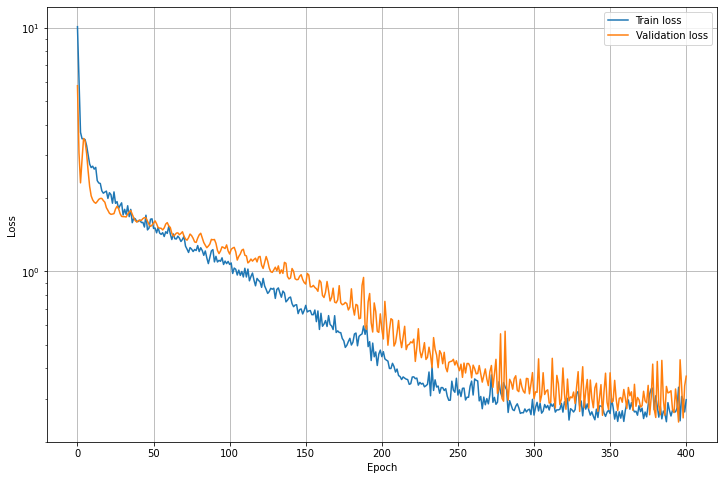

Average train      loss in the last 10 epochs: 0.2821
Average validation loss in the last 10 epochs: 0.3123


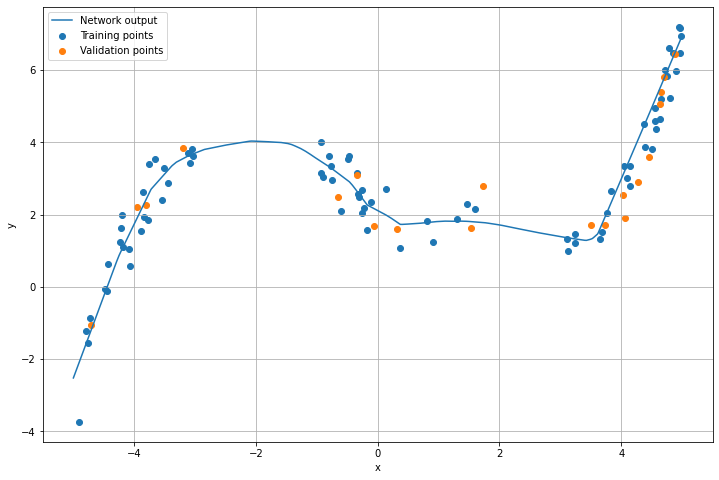

In [ ]:
idx = 2

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

### Momentum

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.SGD
optimizer_params = {'lr': 0.001, 'momentum': 0.01}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [20] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(1.0954025, 1.3422434)

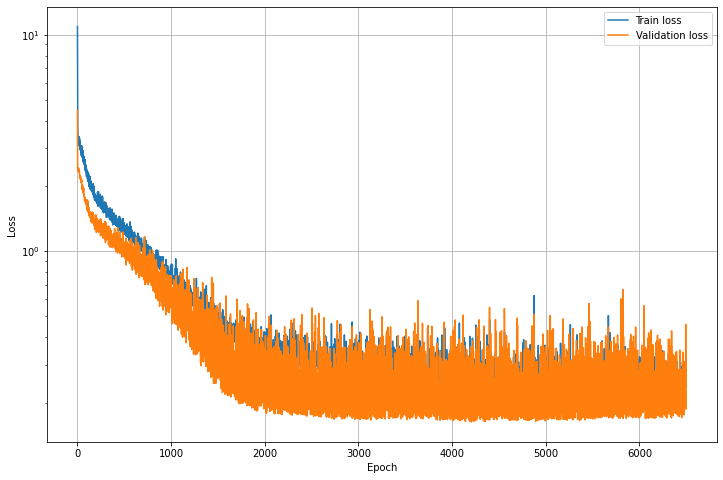

Average train      loss in the last 10 epochs: 0.2560
Average validation loss in the last 10 epochs: 0.2743


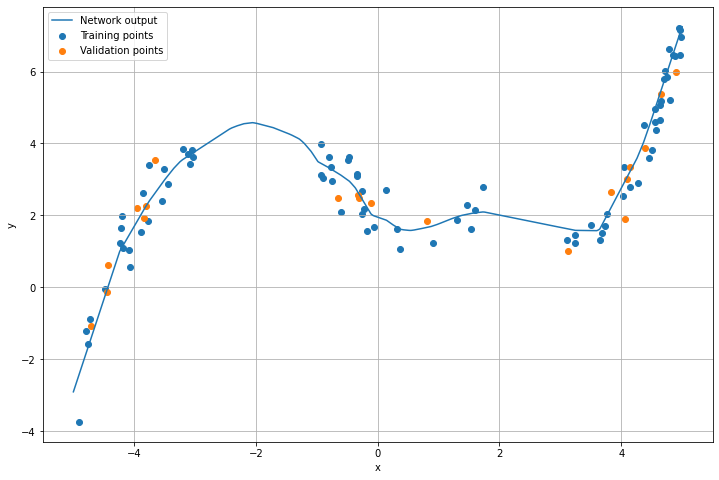

In [ ]:
idx = 4

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

### Weight decay

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.01}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [20] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(2000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.27539033, 0.35953712)

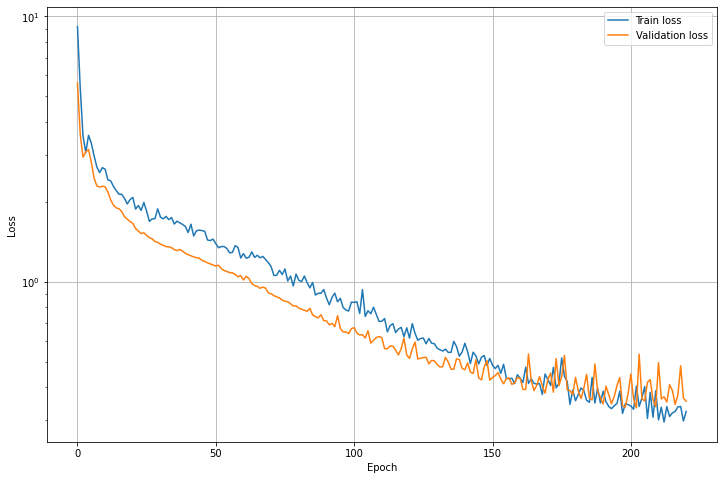

Average train      loss in the last 10 epochs: 0.3223
Average validation loss in the last 10 epochs: 0.3800


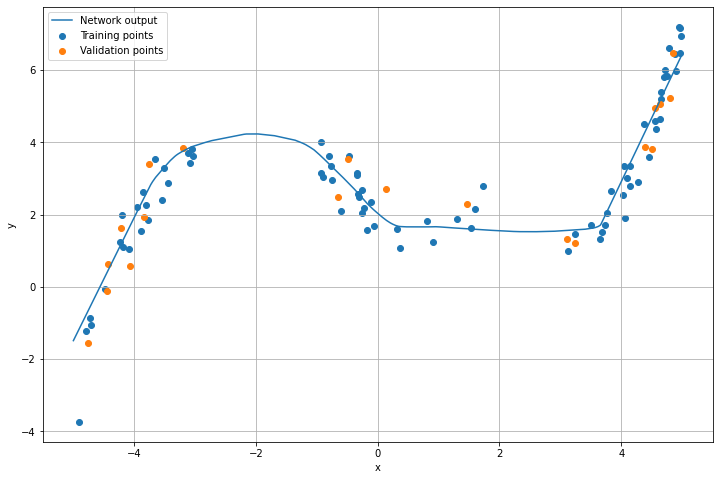

In [ ]:
idx = 3

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

### Dropout

In [ ]:
class Net_d(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No, dropout_prob, activation_function):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=No)
    self.dropout = nn.Dropout(p=dropout_prob)

    self.act = activation_function

    print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.dropout(x)
    x = self.act(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
dropout_prob = 0.3
activation_function = nn.ReLU()

net_type = Net_d
net_params = [Ni,Nh1,Nh2,No,dropout_prob,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = [0.001] # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [100] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.52572, 0.40406817)

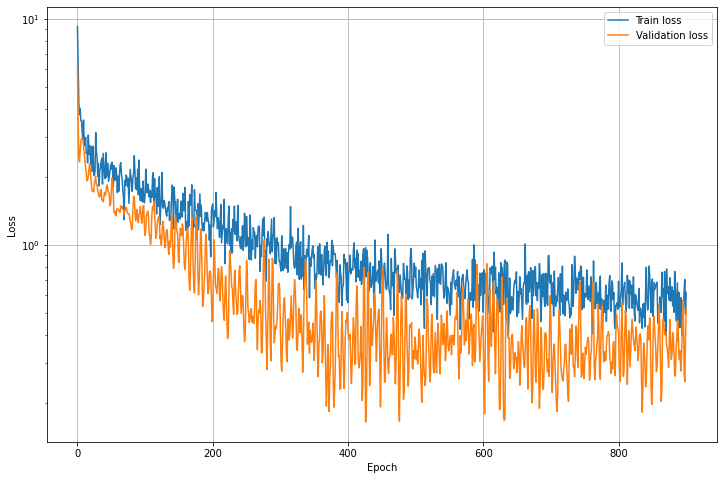

Average train      loss in the last 10 epochs: 0.5504
Average validation loss in the last 10 epochs: 0.3828


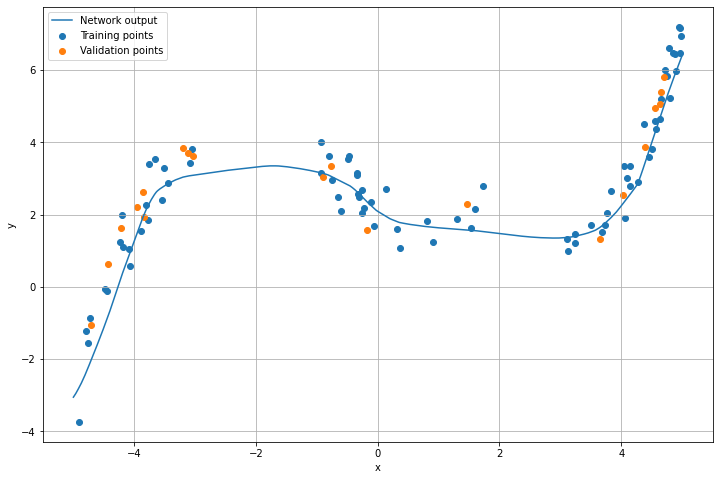

In [ ]:
idx = 0

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

### Trying a deeper net

In [11]:
class Net3(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, Nh3, No, activation_function):
    '''
    Network with 3 hidden linear layers
    '''
    super().__init__()

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
    self.out = nn.Linear(in_features=Nh3,out_features=No)

    self.act = activation_function

    print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 20
Nh3 = 128
activation_function = nn.ReLU()

net_type = Net3
net_params = [Ni,Nh1,Nh2,Nh3,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.01} # learining rate

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [200] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.22945681, 0.31193227)

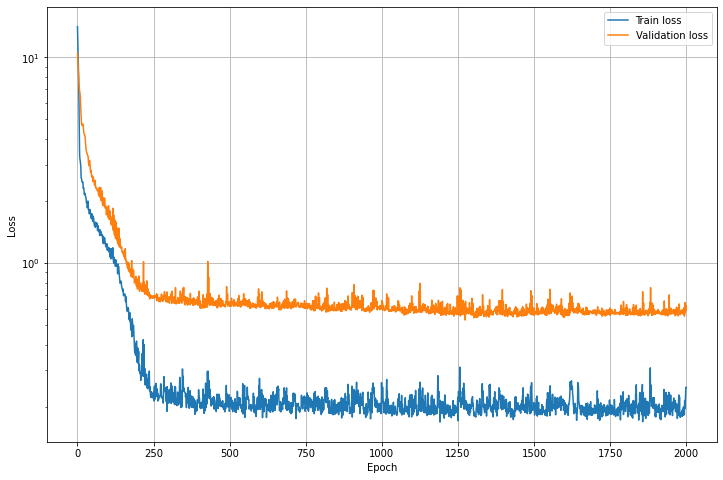

Average train      loss in the last 10 epochs: 0.2108
Average validation loss in the last 10 epochs: 0.5878


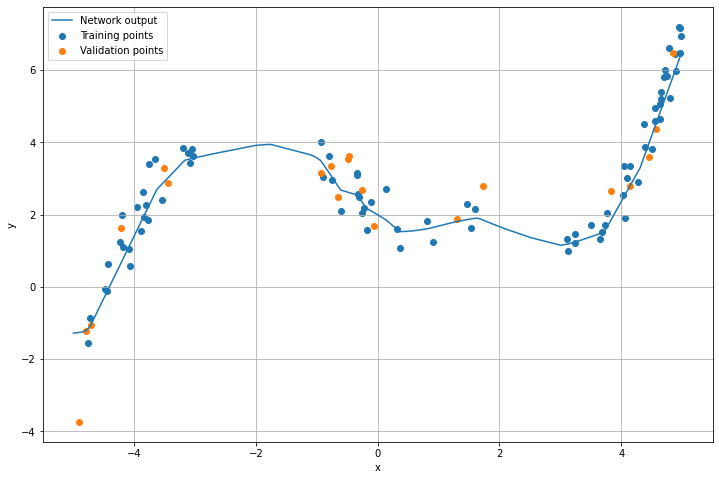

In [ ]:
idx = 0

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

In [12]:
class Net4(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, Nh3, Nh4, No, activation_function):
    '''
    Network with 3 hidden linear layers
    '''
    super().__init__()

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
    self.fc4 = nn.Linear(in_features=Nh3, out_features=Nh4)
    self.out = nn.Linear(in_features=Nh4,out_features=No)

    self.act = activation_function

    print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.act(self.fc4(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
Nh3 = 128
Nh4 = 128
activation_function = nn.Tanh()

net_type = Net4
net_params = [Ni,Nh1,Nh2,Nh3,Nh4,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.0}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [200] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.21404323, 0.35719097)

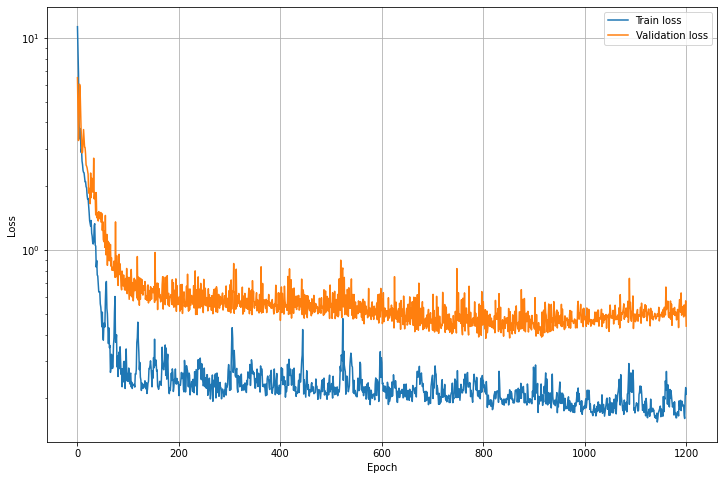

Average train      loss in the last 10 epochs: 0.1907
Average validation loss in the last 10 epochs: 0.5145


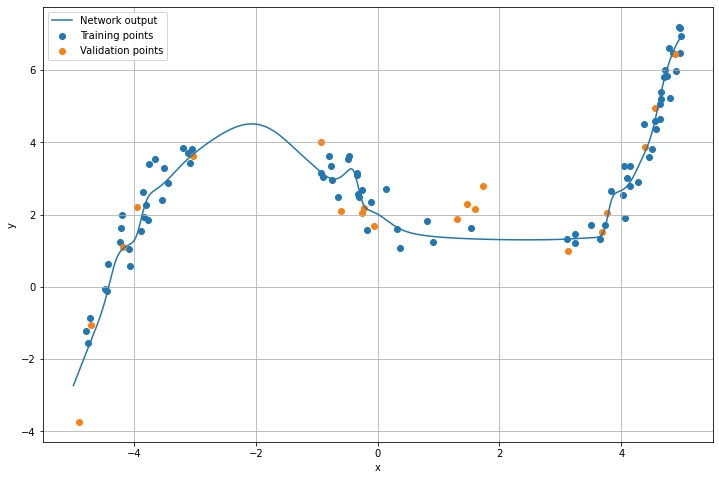

In [ ]:
idx = 0

kf.evolvers[idx].plot_losses()

kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

## Optimizing the hyperparameters

In [13]:
# possible hyperparams

Nh1s = Nh2s = Nh3s = Nh4s = [16, 32, 64, 128, 256]
activation_functions = [nn.Sigmoid(), nn.Tanh(), nn.ReLU()]

optimizer_type = optim.Adam
lrs = [0.0001, 0.001, 0.01]
weight_decays = [0, 0.001, 0.01, 0.1]

train_batch_sizes = [10, 20, 30, 40]

patiences = [20, 200, 500]

### Random search

In [ ]:
df = pd.DataFrame(data=[], columns=['Nh1','Nh2','Nh3','Nh4','activation_function', 'lr','weight_decay','train_batch_size','patience', 'avg_train_loss', 'avg_val_loss'])

In [24]:
files.upload()

Saving random_search.csv to random_search.csv


{'random_search.csv': b'Nh1,Nh2,Nh3,Nh4,activation_function,lr,weight_decay,train_batch_size,patience,avg_train_loss,avg_val_loss\n64,256,64,32,ReLU(),0.01,0,40,20,0.295972049236298,0.408583402633667\n128,16,128,16,Tanh(),0.0001,0.1,10,200,1.89785134792328,2.13166570663452\n128,64,32,32,ReLU(),0.001,0.001,30,500,0.167426690459251,0.331603556871414\n256,16,64,32,ReLU(),0.0001,0.001,30,500,0.172863870859146,0.276303678750992\n64,64,64,128,Tanh(),0.01,0,10,200,1.97570633888245,1.90064120292664\n32,64,128,32,ReLU(),0.0001,0,20,500,0.170384377241135,0.289366543292999\n32,64,32,256,Tanh(),0.0001,0.001,30,200,0.243282198905945,0.304428964853287\n32,64,16,32,Tanh(),0.0001,0.001,40,20,0.689234137535095,0.550953149795532\n16,256,128,256,ReLU(),0.001,0.01,10,200,0.245566323399544,0.36766391992569\n16,128,128,32,ReLU(),0.0001,0.001,30,500,0.185615628957748,0.306545823812485\n256,128,128,256,ReLU(),0.0001,0,10,20,0.28080677986145,0.346840143203735\n256,16,16,256,ReLU(),0.001,0,20,500,0.159130886197

In [25]:
df = pd.read_csv('random_search.csv')

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          256
Nh2                          128
Nh3                           16
Nh4                           64
activation_function    Sigmoid()
lr                        0.0001
weight_decay                 0.1
train_batch_size              10
patience                      20
avg_train_loss            3.7912
avg_val_loss             3.76637
Name: 24, dtype: object


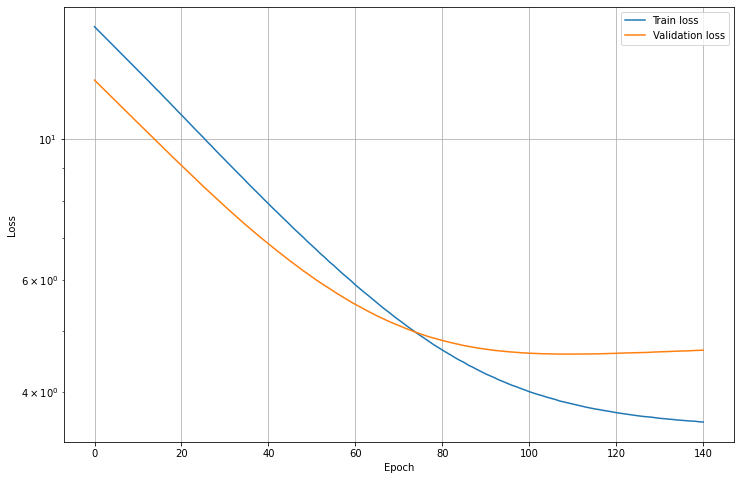

Average train      loss in the last 10 epochs: 3.6133
Average validation loss in the last 10 epochs: 4.6456


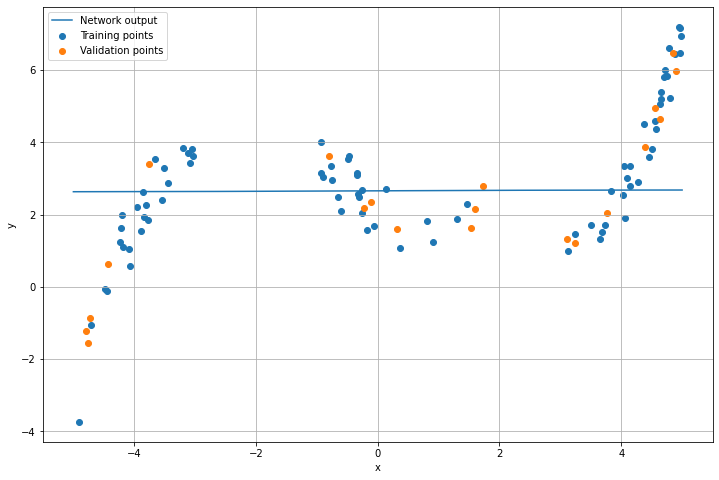

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          128
Nh2                           16
Nh3                          128
Nh4                           32
activation_function    Sigmoid()
lr                          0.01
weight_decay                0.01
train_batch_size              20
patience                      20
avg_train_loss           3.83537
avg_val_loss             3.87984
Name: 25, dtype: object



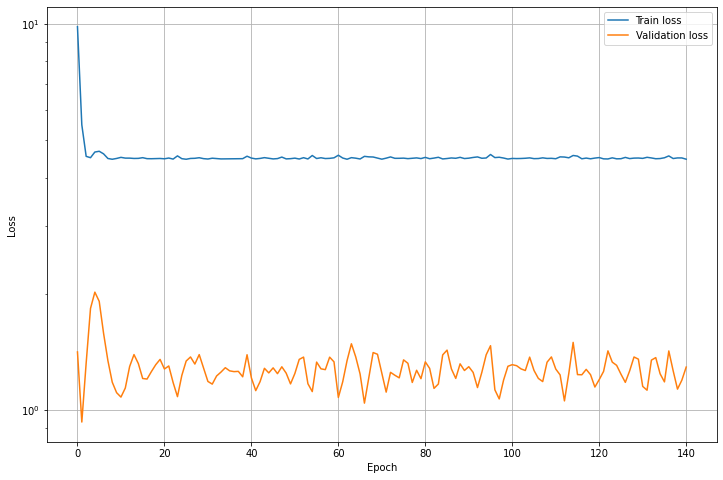

Average train      loss in the last 10 epochs: 4.4961
Average validation loss in the last 10 epochs: 1.2585


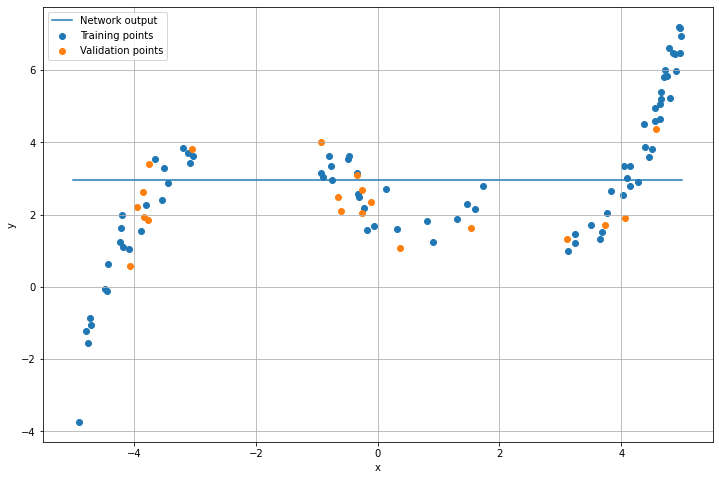

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          32
Nh2                         256
Nh3                         128
Nh4                          32
activation_function      ReLU()
lr                       0.0001
weight_decay                0.1
train_batch_size             30
patience                     20
avg_train_loss          0.39294
avg_val_loss           0.483314
Name: 26, dtype: object


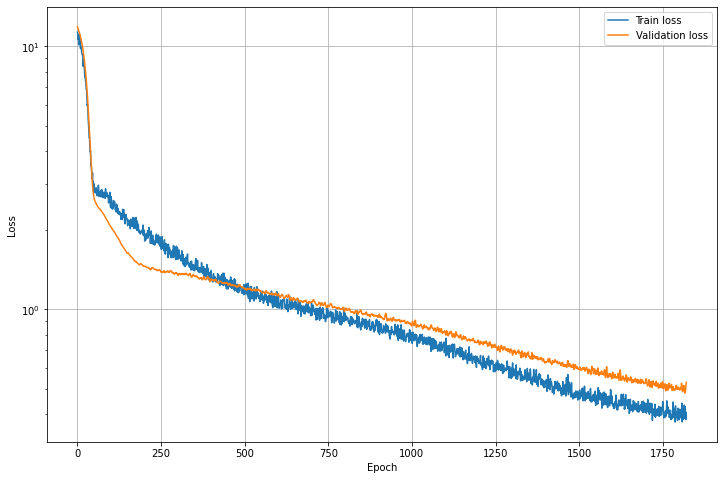

Average train      loss in the last 10 epochs: 0.4082
Average validation loss in the last 10 epochs: 0.5013


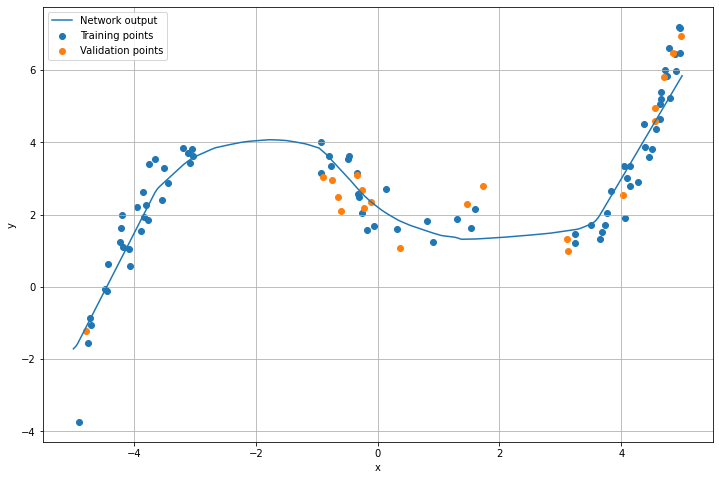

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                           64
Nh2                           16
Nh3                           16
Nh4                           64
activation_function    Sigmoid()
lr                          0.01
weight_decay               0.001
train_batch_size              20
patience                     200
avg_train_loss           0.47388
avg_val_loss            0.982342
Name: 27, dtype: object


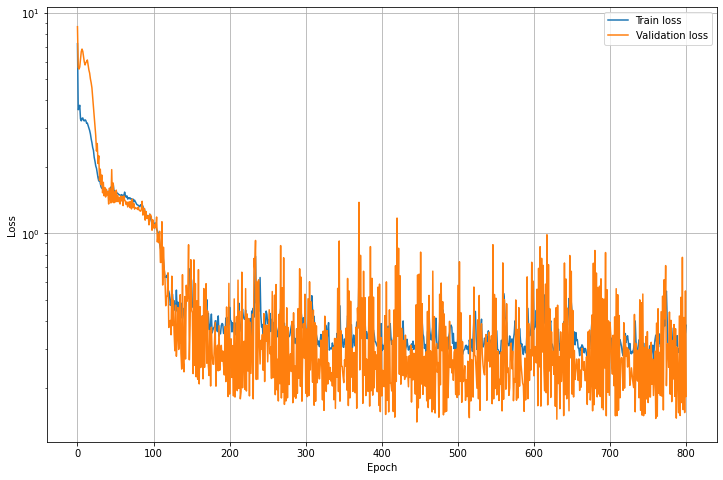

Average train      loss in the last 10 epochs: 0.3495
Average validation loss in the last 10 epochs: 0.3493


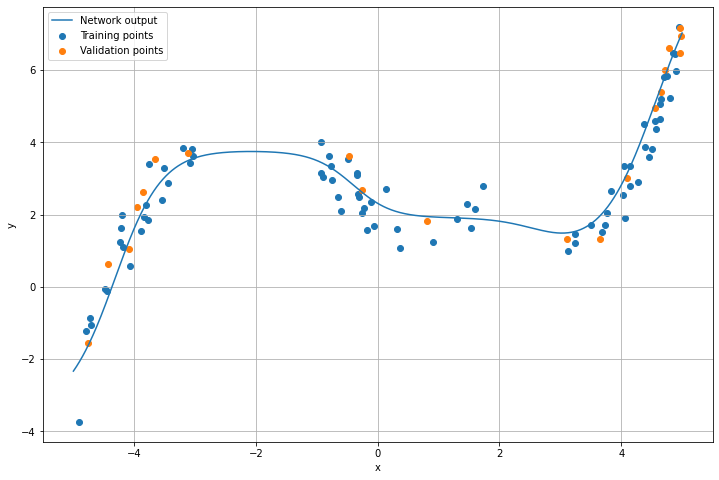

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                           64
Nh2                           64
Nh3                          128
Nh4                          256
activation_function    Sigmoid()
lr                         0.001
weight_decay                 0.1
train_batch_size              20
patience                     200
avg_train_loss           3.82774
avg_val_loss             3.89406
Name: 28, dtype: object


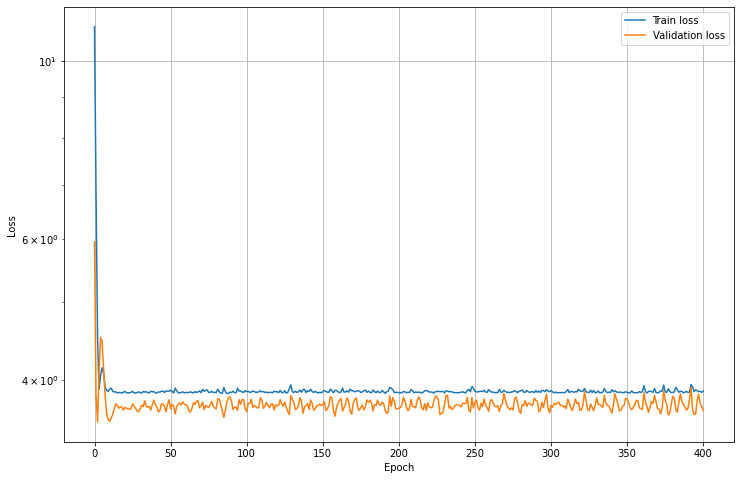

Average train      loss in the last 10 epochs: 3.8809
Average validation loss in the last 10 epochs: 3.7310


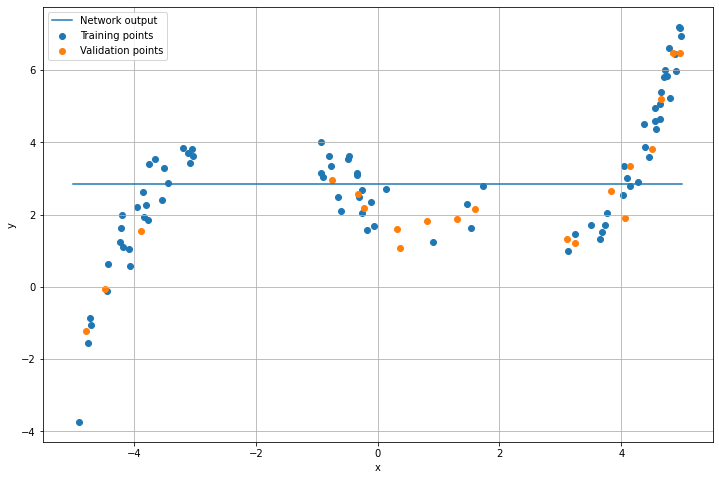

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          32
Nh2                         256
Nh3                          16
Nh4                          32
activation_function      ReLU()
lr                       0.0001
weight_decay               0.01
train_batch_size             20
patience                    500
avg_train_loss         0.214284
avg_val_loss           0.319568
Name: 29, dtype: object


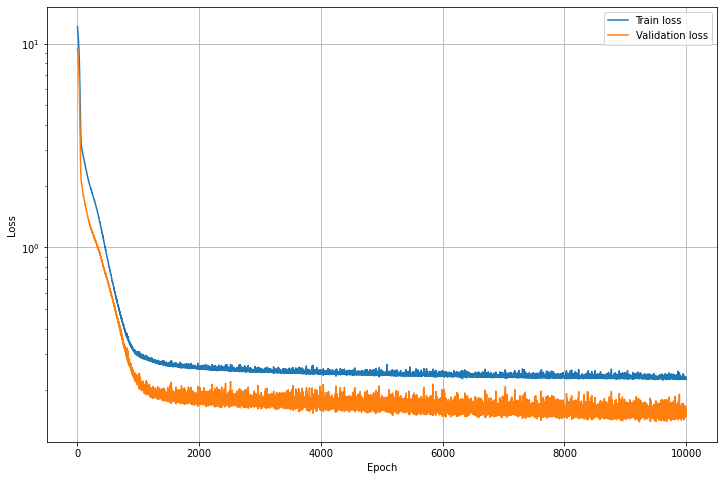

Average train      loss in the last 10 epochs: 0.2278
Average validation loss in the last 10 epochs: 0.1536


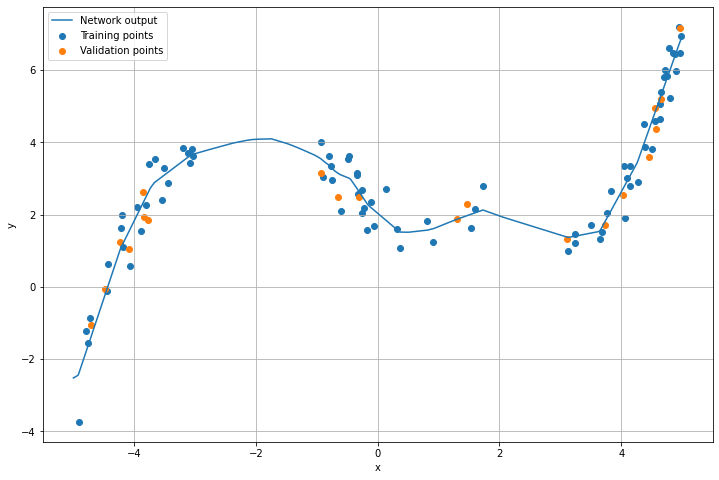

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                           16
Nh2                          256
Nh3                          256
Nh4                          256
activation_function    Sigmoid()
lr                         0.001
weight_decay                 0.1
train_batch_size              40
patience                     500
avg_train_loss           3.80294
avg_val_loss             4.00213
Name: 30, dtype: object


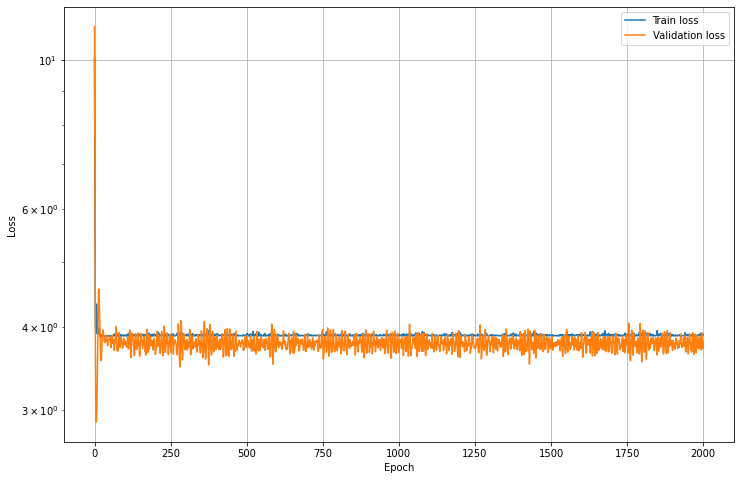

Average train      loss in the last 10 epochs: 3.8880
Average validation loss in the last 10 epochs: 3.7758


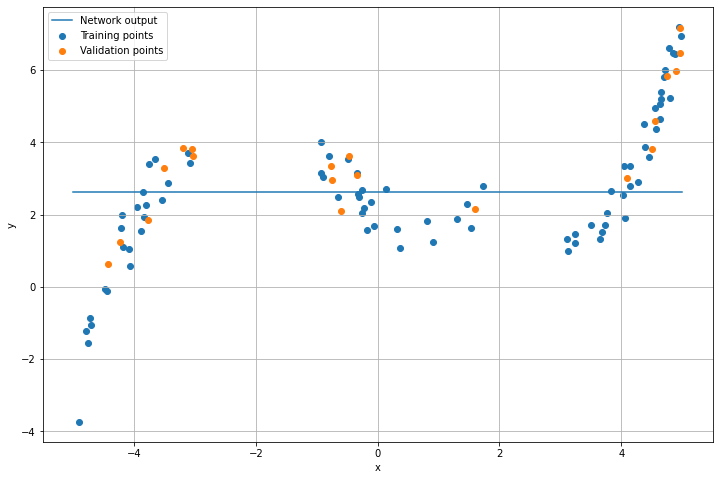

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          64
Nh2                          16
Nh3                          32
Nh4                         128
activation_function      Tanh()
lr                        0.001
weight_decay               0.01
train_batch_size             30
patience                     20
avg_train_loss         0.299173
avg_val_loss           0.376115
Name: 31, dtype: object


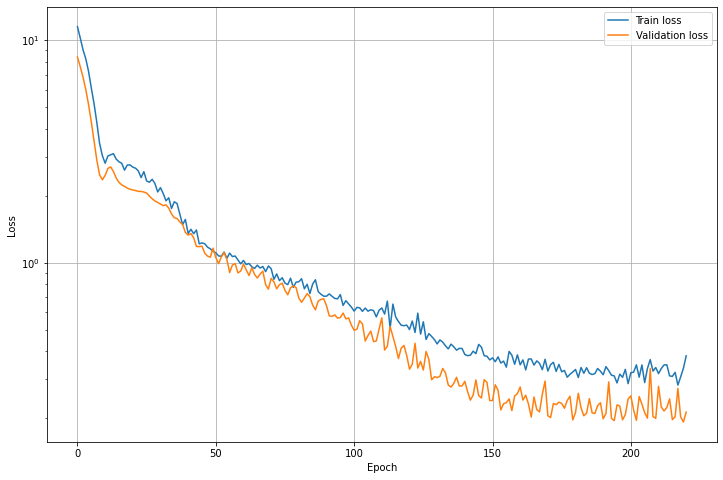

Average train      loss in the last 10 epochs: 0.3272
Average validation loss in the last 10 epochs: 0.2185


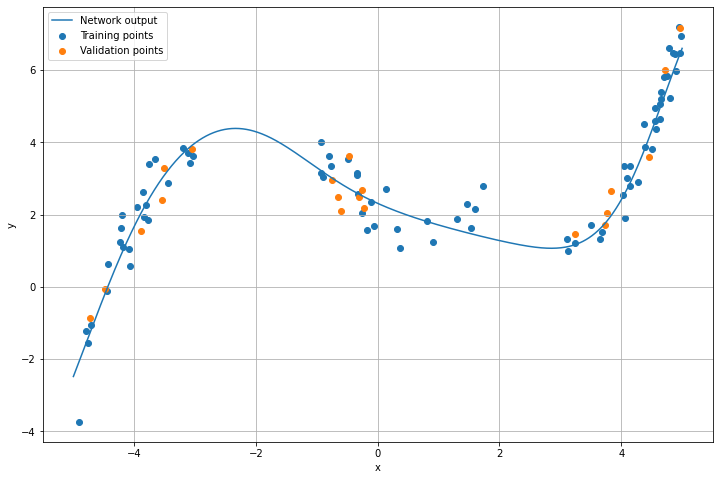

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          16
Nh2                          32
Nh3                         256
Nh4                         256
activation_function      ReLU()
lr                        0.001
weight_decay              0.001
train_batch_size             40
patience                    200
avg_train_loss         0.175781
avg_val_loss           0.411058
Name: 32, dtype: object


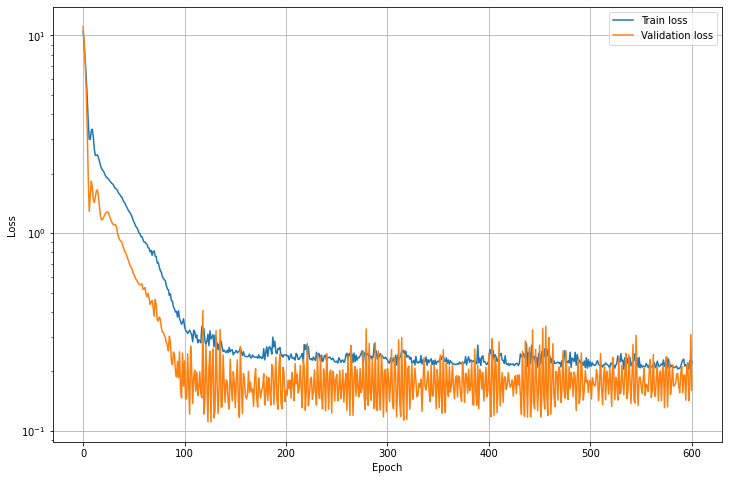

Average train      loss in the last 10 epochs: 0.2180
Average validation loss in the last 10 epochs: 0.1897


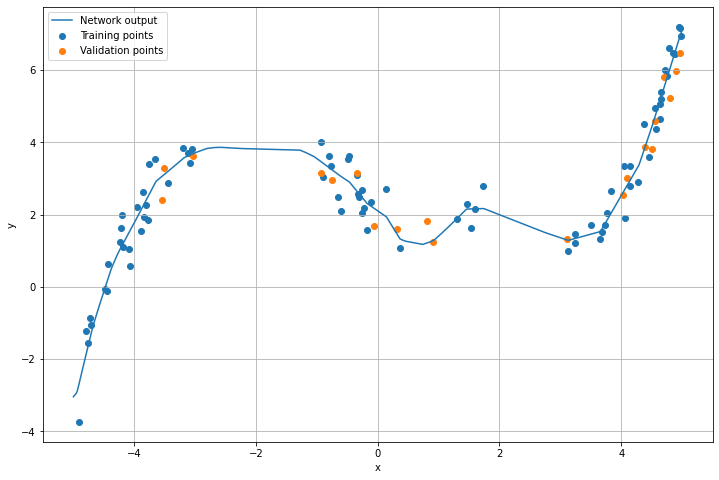

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nh1                          256
Nh2                           16
Nh3                           32
Nh4                          128
activation_function    Sigmoid()
lr                          0.01
weight_decay               0.001
train_batch_size              40
patience                     500
avg_train_loss          0.277426
avg_val_loss            0.375012
Name: 33, dtype: object


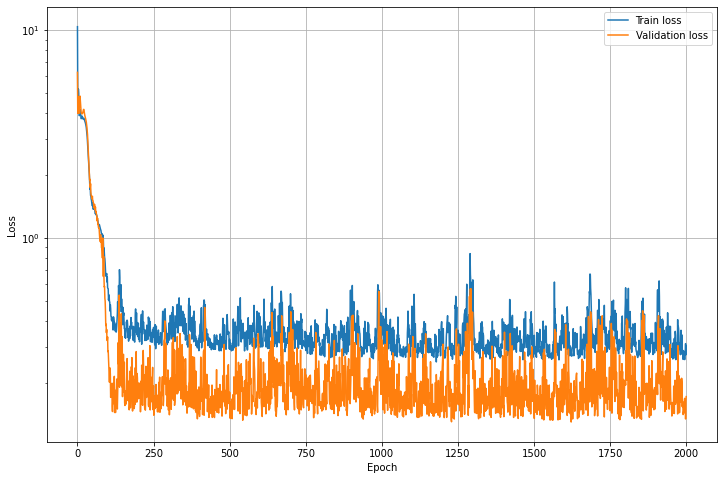

Average train      loss in the last 10 epochs: 0.2846
Average validation loss in the last 10 epochs: 0.1564


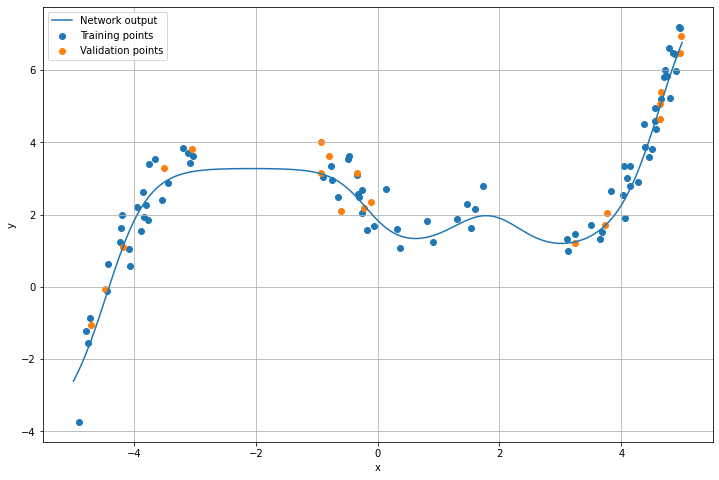

In [29]:
iterations = 10

k = 5
Ni = No = 1

for i in range(iterations):

  # choose hyperparams
  net_type = Net4

  Nh1 = np.random.choice(Nh1s)
  Nh2 = np.random.choice(Nh2s)
  Nh3 = np.random.choice(Nh3s)
  Nh4 = np.random.choice(Nh4s)
  activation_function = np.random.choice(activation_functions)
  net_params = [Ni,Nh1,Nh2,Nh3,Nh4,No,activation_function]

  optimizer_type = optim.Adam
  lr = np.random.choice(lrs)
  weight_decay = np.random.choice(weight_decays)
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}

  loss_function = nn.MSELoss()

  train_batch_size = int(np.random.choice(train_batch_sizes))

  evolver_type = Evolver_es
  patience = np.random.choice(patiences)
  evolver_additional_params = [patience]
  
  # K fold
  kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

  avg_train_loss, avg_val_loss = kf.run(10000)
  # avg_train_loss, avg_val_loss = 0,0

  df.loc[len(df)] = [Nh1,Nh2,Nh3,Nh4,activation_function, lr,weight_decay,train_batch_size,patience, avg_train_loss,avg_val_loss]
  df.to_csv('random_search.csv',index=False)
  files.download('random_search.csv')
  print(df.loc[len(df) - 1])

  idx = 0
  kf.evolvers[idx].plot_losses()
  kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

In [28]:
files.download('random_search.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
df

,Nh1,Nh2,Nh3,Nh4,activation_function,lr,weight_decay,train_batch_size,patience,avg_train_loss,avg_val_loss
0,64,256,64,32,ReLU(),0.0100,0.000,40,20,0.295972,0.408583
1,128,16,128,16,Tanh(),0.0001,0.100,10,200,1.897851,2.131666
2,128,64,32,32,ReLU(),0.0010,0.001,30,500,0.167427,0.331604
3,256,16,64,32,ReLU(),0.0001,0.001,30,500,0.172864,0.276304
4,64,64,64,128,Tanh(),0.0100,0.000,10,200,1.975706,1.900641
5,32,64,128,32,ReLU(),0.0001,0.000,20,500,0.170384,0.289367
6,32,64,32,256,Tanh(),0.0001,0.001,30,200,0.243282,0.304429
7,32,64,16,32,Tanh(),0.0001,0.001,40,20,0.689234,0.550953
8,16,256,128,256,ReLU(),0.0010,0.010,10,200,0.245566,0.367664
9,16,128,128,32,ReLU(),0.0001,0.001,30,500,0.185616,0.306546


#### Analyzing the results

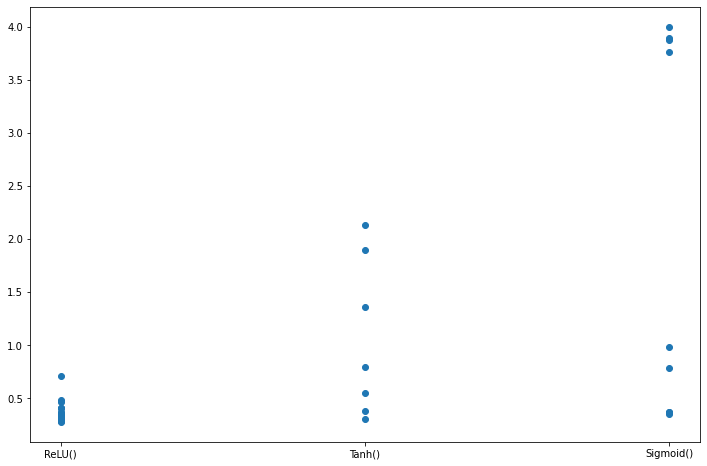

In [60]:
plt.figure(figsize=(12,8))
plt.scatter([str(a) for a in df.activation_function],df.avg_val_loss)

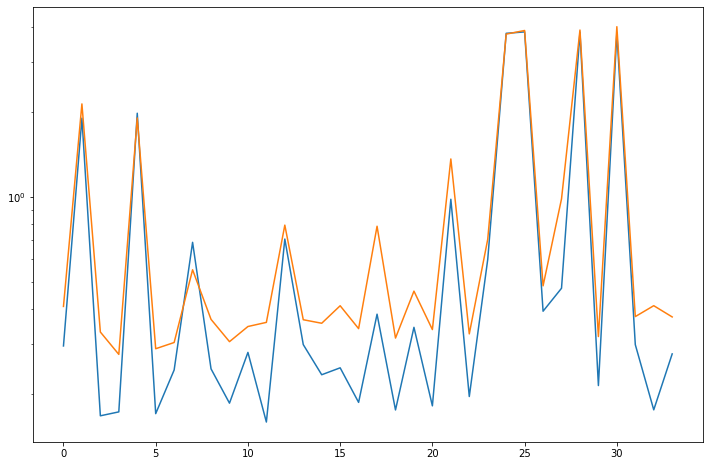

In [33]:
plt.figure(figsize=(12,8))
plt.semilogy(df.avg_train_loss)
plt.semilogy(df.avg_val_loss)

In [35]:
best_idx = np.argmin(df.avg_val_loss)
best_idx

3

In [36]:
df.loc[best_idx]

Nh1                         256
Nh2                          16
Nh3                          64
Nh4                          32
activation_function      ReLU()
lr                       0.0001
weight_decay              0.001
train_batch_size             30
patience                    500
avg_train_loss         0.172864
avg_val_loss           0.276304
Name: 3, dtype: object

## Final test

### Train the net with optimal hyperparameters

In [37]:
k = 5

# net params
Ni = No = 1
Nh1 = 256
Nh2 = 16
Nh3 = 64
Nh4 = 32
activation_function = nn.ReLU()

net_type = Net4
net_params = [Ni,Nh1,Nh2,Nh3,Nh4,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.0001, 'weight_decay': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

evolver_type = Evolver_es
evolver_additional_params = [500] # patience


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_df=all_train_df, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

avg_train_loss, avg_val_loss = kf.run(10000)

Network initialized
Network initialized
Network initialized
Network initialized
Network initialized


(0.1936491, 0.29968366)

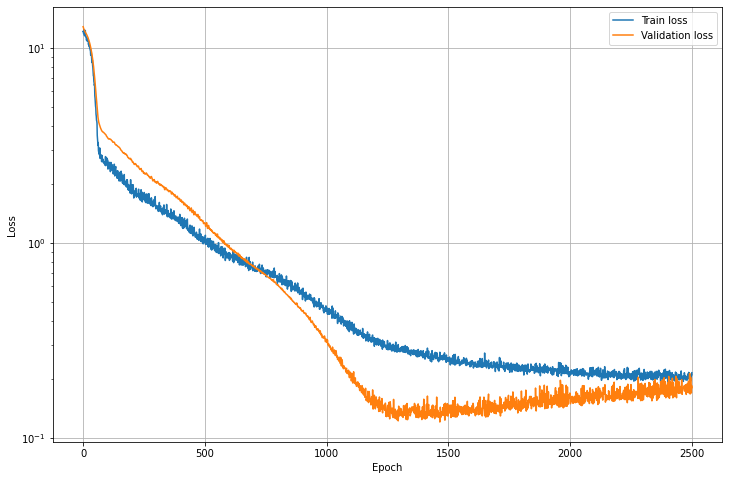

Average train      loss in the last 10 epochs: 0.2083
Average validation loss in the last 10 epochs: 0.1875


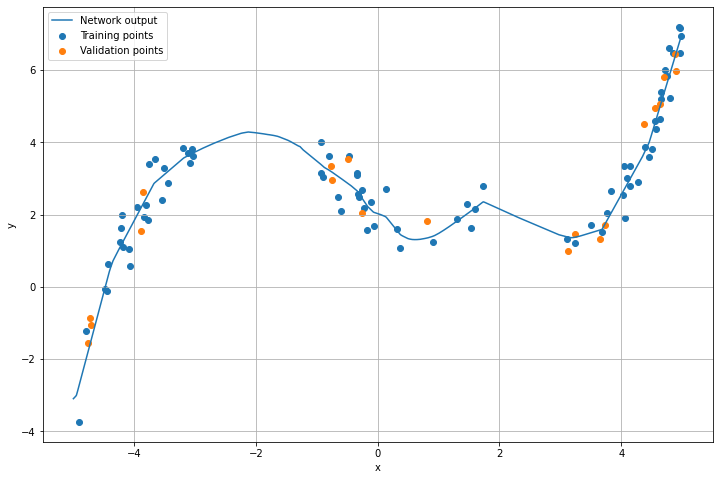

In [45]:
idx = 0
kf.evolvers[idx].plot_losses()
kf.evolvers[idx].plot(kf.train_dfs[idx],kf.val_dfs[idx])

In [44]:
# select best net

print([ev.val_loss_log[-1] for ev in kf.evolvers])
idx = np.argmin([ev.val_loss_log[-1] for ev in kf.evolvers])
print(idx)

[0.1815943, 0.29415783, 0.4844017, 0.21447709, 0.32831126]
0


### Test the best net

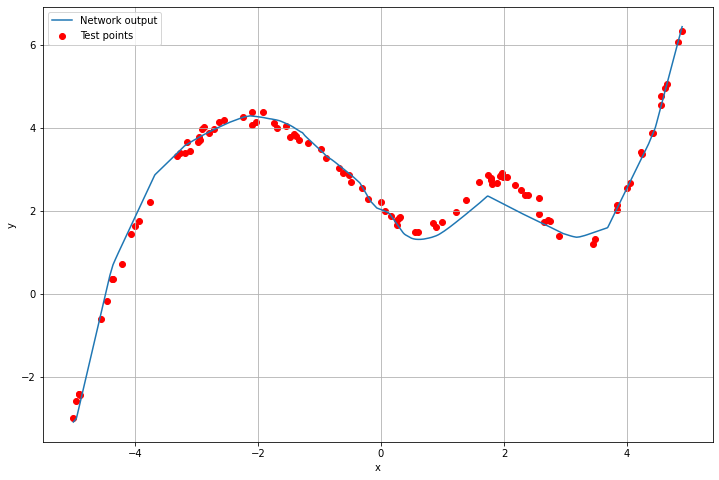

Average test loss: 0.078


0.078245

In [46]:
kf.evolvers[idx].test(test_df, plot=True)

In [49]:
# save and download net
torch.save(kf.evolvers[idx].net.state_dict(), 'best_net.pth')
torch.save(kf.evolvers[idx].optimizer.state_dict(), 'best_net_optim.pth')
files.download('best_net.pth')
files.download('best_net_optim.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
best_hyperparams = pd.DataFrame(data=[], columns=['Nh1','Nh2','Nh3','Nh4','activation_function', 'lr','weight_decay',
                                                  'train_batch_size','patience', 'avg_train_loss', 'avg_val_loss'])
best_hyperparams.loc[0] = [Nh1,Nh2,Nh3,Nh4,activation_function, lr,weight_decay,train_batch_size,patience, avg_train_loss,avg_val_loss]

best_hyperparams.to_csv('best_hyperparams.csv')
files.download('best_hyperparams.pth')

## Visualization of the net

In [61]:
best_net = Net4(1,256,16,64,32,1,nn.ReLU())
best_net_state_dict = torch.load('best_net.pth')
best_net.load_state_dict(best_net_state_dict)

Network initialized


<All keys matched successfully>

### Weights

In [63]:
h1_w = best_net.fc1.weight.data.cpu().numpy()
h2_w = best_net.fc2.weight.data.cpu().numpy()
h3_w = best_net.fc3.weight.data.cpu().numpy()
h4_w = best_net.fc4.weight.data.cpu().numpy()
out_w = best_net.out.weight.data.cpu().numpy()

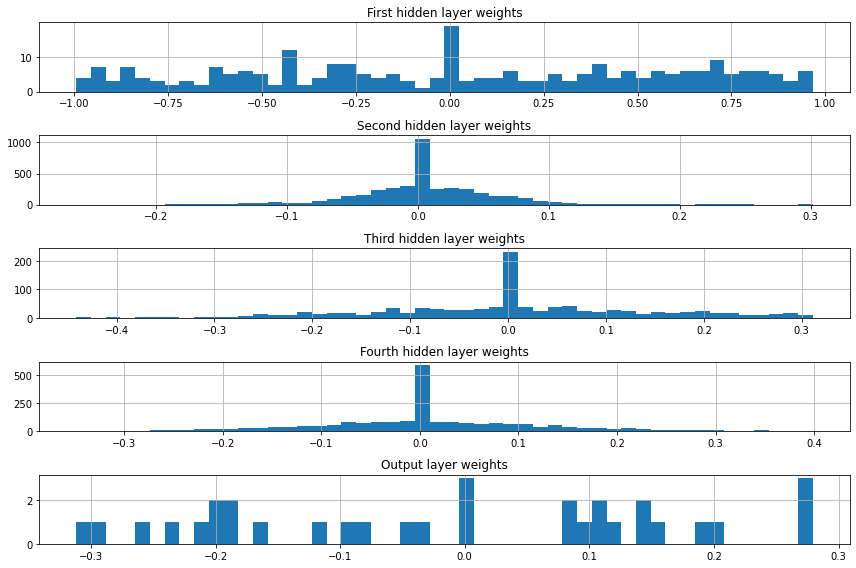

In [65]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('Fourth hidden layer weights')
axs[4].hist(out_w.flatten(), 50)
axs[4].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

It makes sense that most of the weights are near 0 since the net was trained with L2 penalty on the weights

### Activation profile

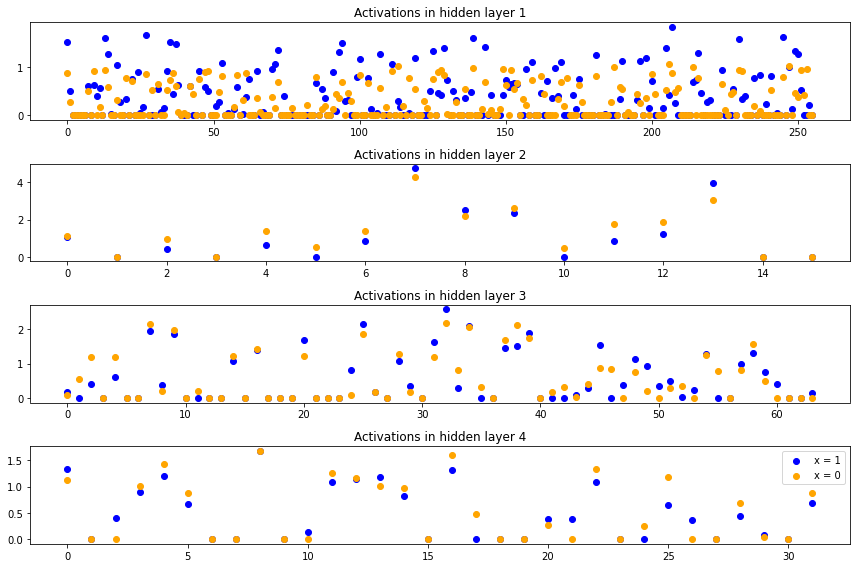

In [75]:
x1 = 1
x2 = 0

#define a hook for each layer

def get_activation1(layer, input, output):
    global activation1 # define global variable in which to store the activations.
    activation1 = torch.relu(output)

hook_handle1 = best_net.fc1.register_forward_hook(get_activation1)

def get_activation2(layer, input, output):
    global activation2 # define global variable in which to store the activations.
    activation2 = torch.relu(output)

hook_handle2 = best_net.fc2.register_forward_hook(get_activation2)

def get_activation3(layer, input, output):
    global activation3 # define global variable in which to store the activations.
    activation3 = torch.relu(output)

hook_handle3 = best_net.fc3.register_forward_hook(get_activation3)

def get_activation4(layer, input, output):
    global activation4 # define global variable in which to store the activations.
    activation4 = torch.relu(output)

hook_handle4 = best_net.fc4.register_forward_hook(get_activation4)

# evaluate the net
best_net = best_net.to(device)
best_net.eval()
with torch.no_grad():
    x = torch.tensor([x1]).float().to(device)
    y = best_net(x)
    a1 = activation1.cpu().numpy()
    a2 = activation2.cpu().numpy()
    a3 = activation3.cpu().numpy()
    a4 = activation4.cpu().numpy()

    x = torch.tensor([x2]).float().to(device)
    y = best_net(x)
    a1b = activation1.cpu().numpy()
    a2b = activation2.cpu().numpy()
    a3b = activation3.cpu().numpy()
    a4b = activation4.cpu().numpy()

a_s = [a1,a2,a3,a4]
ab_s = [a1b,a2b,a3b,a4b]

# remove hooks
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()
hook_handle4.remove()

#plot activations
fig, axs = plt.subplots(4,1, figsize=(12,8))
for i,a in enumerate(a_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x1}',color='blue')
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

for i,a in enumerate(ab_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x2}',color='orange')
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

plt.legend()

fig.tight_layout()